In [ ]:
# %%

import torchvision
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

dataset_voc = torchvision.datasets.VOCSegmentation(
    "/data/pascal_voc/",
    year="2012",
    download=True,
    image_set="val",
)
print("number of images in the dataset:", len(dataset_voc))

Using downloaded and verified file: /data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /data/pascal_voc/VOCtrainval_11-May-2012.tar to /data/pascal_voc/
number of images in the dataset: 1449


In [ ]:
# %%

from ncut_feature_extractors import image_dinov2_feature as feature_extractor

# create a large-scale feature matrix
images = [dataset_voc[i][0] for i in range(8)]
feats = feature_extractor(images, resolution=(448, 448), layer=9)
print("Feature shape for 8 images:", feats.shape)
num_nodes = np.prod(feats.shape[:3])
print("Number of nodes for 8 images:", num_nodes)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Feature shape for 8 images: torch.Size([8, 32, 32, 768])
Number of nodes for 8 images: 8192


In [ ]:
# %%

from ncut_pytorch import NCUT
import time

input_feats = feats.reshape(num_nodes, -1)

start = time.time()
eigenvectors, eigenvalues = NCUT(
    num_eig=30, num_sample=30000, knn=10, t=0.3, device="cpu"
).fit_transform(input_feats)
end = time.time()
print("Nyström ncut time: {:.3f}".format(end - start))

Nyström ncut time: 0.742


In [ ]:
# %%

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def plot_3d(X_3d, rgb, title):

    rand_indices = np.random.choice(num_nodes, 10000)

    fig, axs = plt.subplots(1, 3, figsize=(8, 3), subplot_kw={"projection": "3d"})
    # plot 3 views of the 3D t-SNE, scatter plot, color by RGB
    # use 3D axes to show the 3D t-SNE
    for i, ax in enumerate(axs):
        ax.scatter(*X_3d[rand_indices].T, c=rgb[rand_indices], s=1)
        ax.view_init(elev=30, azim=45 * i)
        # ax.set_title(f"View {i}")
    if len(title) > 0:
        plt.suptitle(title, fontsize=16)
    plt.show()


def plot_sphere(X_3d, rgb, title):

    rand_indices = np.random.choice(num_nodes, 10000)

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    # plot 3 views of the 3D t-SNE, scatter plot, color by RGB
    # use 3D axes to show the 3D t-SNE
    for i, ax in enumerate(axs[:2]):
        ax.axis("off")
        ax = fig.add_subplot(1, 3, i + 1, projection="3d")
        ax.scatter(*X_3d[rand_indices].T, c=rgb[rand_indices], s=1)
        ax.view_init(elev=30, azim=45 * i)
        # ax.set_title(f"View {i}")

    from ncut_pytorch import flatten_sphere

    X_2d = flatten_sphere(X_3d)

    rand_indices = np.random.choice(num_nodes, 10000)
    axs[2].scatter(*X_2d[rand_indices].T, c=rgb[rand_indices], s=1)
    axs[2].set_title("sphere surface")
    axs[2].axis("off")
    if len(title) > 0:
        plt.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()


def plot_images(images, rgb, title):
    fig, axs = plt.subplots(2, 8, figsize=(10, 2))
    for i_row in range(0, 2, 2):
        for i_col in range(8):
            ax = axs[i_row, i_col]
            image = images[i_row * 8 + i_col]
            image = image.resize((224, 224), Image.BILINEAR)
            ax.imshow(image)
            ax.axis("off")
        for i_col in range(8):
            ax = axs[i_row + 1, i_col]
            ax.imshow(rgb[i_row * 8 + i_col])
            ax.axis("off")
    if len(title) > 0:
        plt.suptitle(title, fontsize=16)
    plt.show()

In [ ]:
# %%

# apply umap for visualization of the eigenvectors
from ncut_pytorch import rgb_from_umap_sphere

start = time.time()
X_3d, rgb = rgb_from_umap_sphere(
    eigenvectors,
    n_neighbors=100,
    min_dist=0.1,
)
end = time.time()
print("UMAP time: {:.3f}".format(end - start))

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP time: 66.948


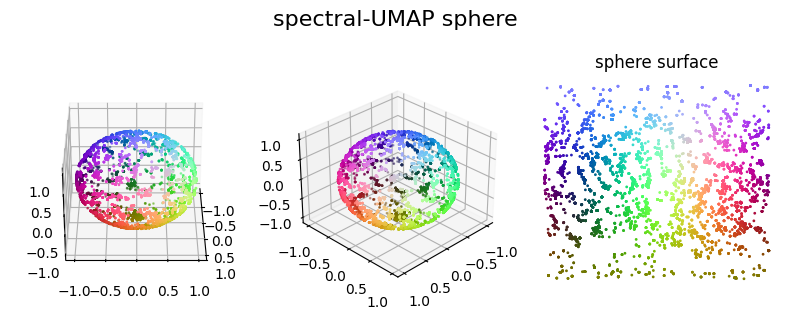

<ipython-input-4-2f7e59cfcb9f>:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


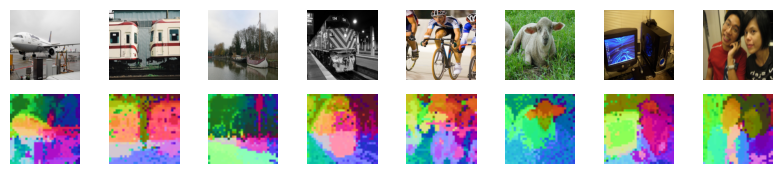

In [ ]:
# %%

plot_sphere(X_3d, rgb, "spectral-UMAP sphere")
image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "")

In [ ]:
# %%

from ncut_pytorch import rgb_from_tsne_3d
import time

start = time.time()
X_3d, rgb = rgb_from_tsne_3d(eigenvectors, perplexity=100)
end = time.time()
print("t-SNE time: {:.3f}".format(end - start))

t-SNE time: 15.641


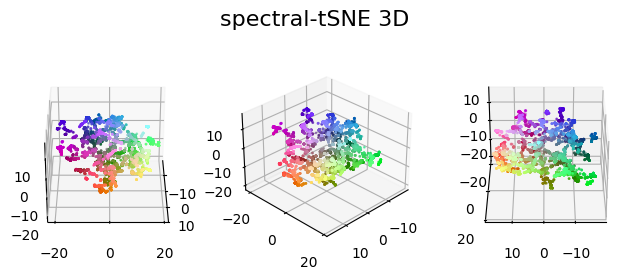

<ipython-input-4-2f7e59cfcb9f>:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


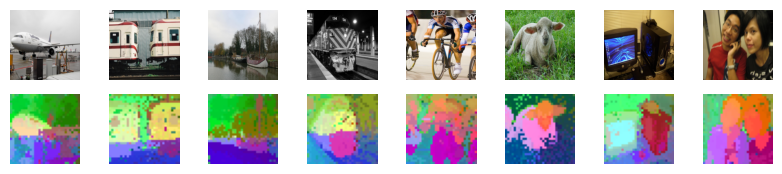

In [ ]:
# %%

plot_3d(X_3d, rgb, "spectral-tSNE 3D")
image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "")

In [ ]:
# %%

from ncut_pytorch import rgb_from_umap_3d
import time

start = time.time()
X_3d, rgb = rgb_from_umap_3d(
    eigenvectors,
    n_neighbors=100,
    min_dist=0.1,
)
end = time.time()
print("UMAP time: {:.3f}".format(end - start))

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP time: 11.862


/workspace/ncut_pytorch.py:751: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rgb = rgb_from_3d(torch.tensor(X_3d), q=q)


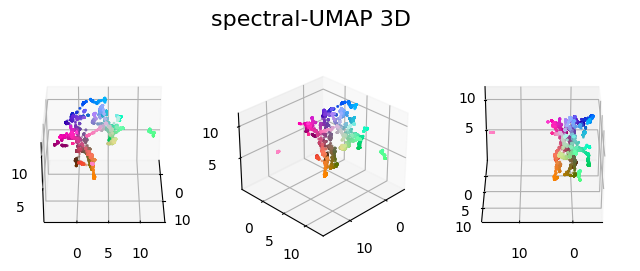

<ipython-input-4-2f7e59cfcb9f>:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


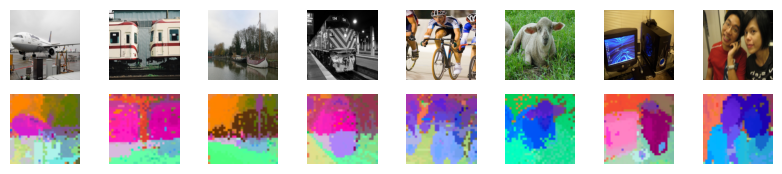

In [ ]:
# %%

plot_3d(X_3d, rgb, "spectral-UMAP 3D")
image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "")

In [ ]:
# %%

from ncut_pytorch import rgb_from_tsne_2d
import time

start = time.time()
X_3d, rgb = rgb_from_tsne_2d(
    eigenvectors,
    perplexity=100,
)
end = time.time()
print("t-SNE time: {:.3f}".format(end - start))

t-SNE time: 8.581


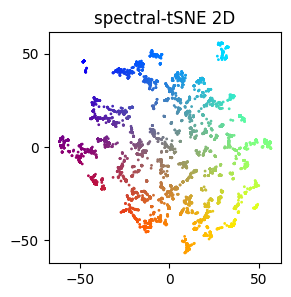

<ipython-input-4-2f7e59cfcb9f>:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


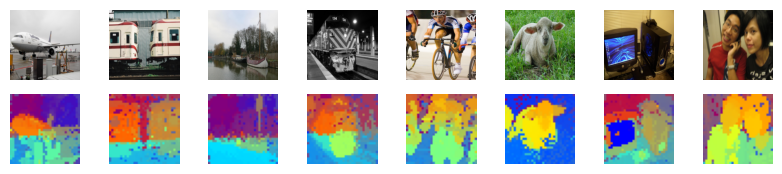

In [ ]:
# %%

fig = plt.figure(figsize=(3, 3))
plt.scatter(*X_3d.T, c=rgb, s=1)
plt.title("spectral-tSNE 2D")
plt.yticks([-50, 0, 50])
plt.xticks([-50, 0, 50])
plt.show()

image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "")

In [ ]:
# %%

from ncut_pytorch import rgb_from_umap_2d
import time

start = time.time()
X_3d, rgb = rgb_from_umap_2d(
    eigenvectors,
    n_neighbors=100,
    min_dist=0.1,
)
end = time.time()
print("t-SNE time: {:.3f}".format(end - start))

/usr/local/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


t-SNE time: 10.762


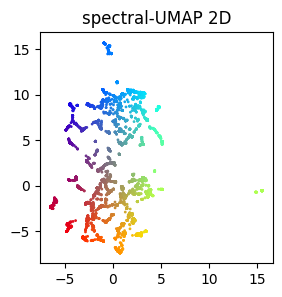

<ipython-input-4-2f7e59cfcb9f>:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


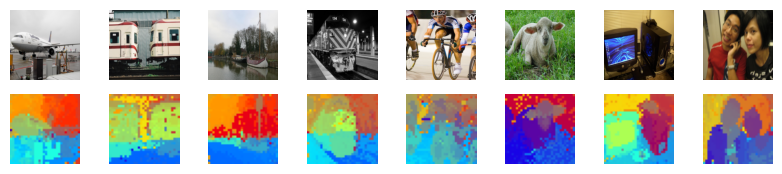

In [ ]:
# %%

fig = plt.figure(figsize=(3, 3))
plt.scatter(*X_3d.T, c=rgb, s=1)
plt.title("spectral-UMAP 2D")
plt.show()

image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "")

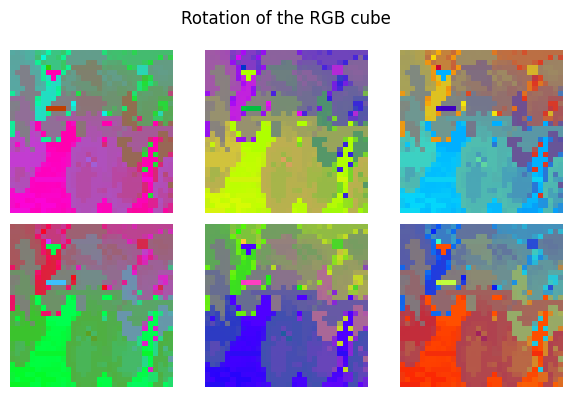

In [ ]:
# %%

# 9-way rotation of the rgb
import matplotlib.pyplot as plt

rotated_rgb = rgb.reshape(feats.shape[:3] + (3,))
fig, axs = plt.subplots(2, 3, figsize=(6, 4))
for i in range(3):
    rotation_matrix = torch.tensor(
        [
            [0, 1, 0],
            [0, 0, 1],
            [1, 0, 0],
        ]
    ).float()
    rotated_rgb = torch.matmul(rotated_rgb, rotation_matrix)
    rotated_rgb = rotated_rgb.reshape(feats.shape[:3] + (3,))
    for j in range(2):
        if j == 0:
            _rgb = rotated_rgb[4]
        else:
            _rgb = 1 - rotated_rgb[4]
        ax = axs[j, i]
        ax.imshow(_rgb)
        ax.axis("off")
plt.suptitle("Rotation of the RGB cube")
plt.tight_layout()
plt.show()